# Generate Datasets for Training and Testing on a single machine

In this notebook, we report the code to generate datasets for training and testing the neural network models.
The datasets contain channel realizations of a realistic LTE link operating over an industry-standard radio channel model.

**Note**: Running this code on a sigle machine might be computationally heavy, therefore we suggest the reader to use a cluster of machine if possible. Please refer to "radio_data/Generate_Data_Distributed.ipynb", in which the same code as in this notebook is structured to be run on a cluster of machines using the package `ray`.

In [1]:
import time
import itpp
import ray
import os

import numpy as np
from matplotlib import pyplot as plt

from src import TDL_channel

In [2]:
def _run_link_simulation(block_size, 
                         modorder,
                         nrof_subcarriers,
                         snr, 
                         channel_coeff):
    
    from src import single_link_bicm_ofdm

    channel_block_fading = np.tile(np.transpose(channel_coeff), (12, 1))
    
    return single_link_bicm_ofdm.simulate(block_size, 
                                          modorder,
                                          nrof_subcarriers,
                                          snr, 
                                          channel_block_fading)

In [3]:
# Channel Generation
fft_size       = 128
channel_model  = 'AWGN'
#relative_speed = 33.33 # m/s

nrof_subcarriers = 72
snrs_db        = np.arange( -5, 30, 1 ) #[5, 10, 15, 20, 25] 

TRANSPORT_BLOCK_SIZES = [152, 200, 248, 320, 408, 504, 600, 712, 808, 936, 
                         936, 1032, 1192, 1352, 1544, 1736, 1800, 
                         1800, 1928, 2152, 2344, 2600, 2792, 2984, 3240, 3496, 3624, 3752, 4008]
MODULATION_ORDERS     = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
                         4, 4, 4, 4, 4, 4, 4, 
                         6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

In [4]:
nrof_snrs = len(snrs_db)
nrof_samples = 100

/usr/lib/python3/dist-packages/ipykernel_launcher.py:42: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


Block size index 0, TBS 176, Elapsed: 6.33s
Block size index 1, TBS 224, Elapsed: 13.62s
Block size index 2, TBS 272, Elapsed: 21.16s
Block size index 3, TBS 344, Elapsed: 29.80s
Block size index 4, TBS 432, Elapsed: 39.59s
Block size index 5, TBS 528, Elapsed: 50.72s
Block size index 6, TBS 624, Elapsed: 63.06s


KeyboardInterrupt: 

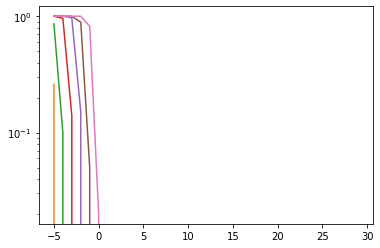

In [5]:
'''Generate the channel realizations'''

channel_coeff = np.ndarray((nrof_samples, nrof_subcarriers, nrof_snrs), dtype=np.complex128)

if channel_model != 'AWGN':
    for snr_index in range(nrof_snrs):
        channel_response = TDL_channel.channel_frequency_response( fft_size,
                                                                   relative_speed,
                                                                   channel_model,
                                                                   nrof_samples )

        channel_coeff[:,:,snr_index] = channel_response.T().to_numpy_ndarray()[:, :nrof_subcarriers]
else:
    channel_coeff[:, :, :] = 1

legend_strings = []

block_success_dataset = np.ndarray((nrof_samples, len( TRANSPORT_BLOCK_SIZES ), nrof_snrs))
channel_to_noise_ratio_dataset = np.ndarray((nrof_subcarriers, nrof_samples, nrof_snrs))

start = time.time()
for block_size_index in range( len( TRANSPORT_BLOCK_SIZES ) ):

    block_size = TRANSPORT_BLOCK_SIZES[ block_size_index]  + 24 # 24 bit CRC
    modorder = MODULATION_ORDERS[ block_size_index ]

    bler_vs_snr = []

    outcome = [_run_link_simulation(block_size, 
                                    modorder,
                                    nrof_subcarriers,
                                    snrs_db[i], 
                                    channel_coeff[:,:,i]) for i in range(nrof_snrs)]

    for snr_index in range(nrof_snrs):
        block_success_dataset[:, block_size_index, snr_index] = outcome[snr_index][1]

        bler_vs_snr.append(outcome[snr_index][0])
   

    legend_strings.append('TBS %df' %(block_size))
    plt.semilogy(snrs_db, bler_vs_snr)

    print('Block size index %d, TBS %d, Elapsed: %0.2fs' %(block_size_index, 
                                                           block_size, 
                                                           time.time() - start))

AWGN_CHANNEL_DATASET = {'block_success': block_success_dataset,
                        'block_sizes': TRANSPORT_BLOCK_SIZES,
                        'snrs_db': snrs_db}

In [6]:
FADING_CHANNEL_DATASET = {'channel': channel_coeff, 
                          'block_success': block_success_dataset,
                          'block_sizes': TRANSPORT_BLOCK_SIZES,
                          'snrs_db': snrs_db}

In [7]:
data_filepath = 'sim_data/sim_0001/'
data_filename = 'dataset.npy'  

if not os.path.exists(data_filepath):
    os.makedirs(data_filepath)  

np.save(data_filepath + data_filename, FADING_CHANNEL_DATASET)